## **Mounting google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/Lung_Cancer_Project/'    #Locating the LIDC-IDRI dataset

In [3]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00


## **Preparing the Datasets**

### **Importing required Libraries and load the datasets**

In [4]:
import os
import glob
import pydicom
import numpy as np

## **Data Loading and Preprocessing**

### **Loading DICOM Images from both datasets**

### **Checking for inconsistent shapes in DICOM Images**

In [5]:
def load_chimdi_dicom_images(folder_path):
    mydicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dcm')]
    images = []
    shapes = []
    for file in mydicom_files:
        dicom = pydicom.dcmread(file)
        if hasattr(dicom, 'pixel_array'):
            image = dicom.pixel_array
            images.append(image)
            shapes.append(image.shape)
    return images, shapes

# Load NSCLC DICOM images and check shapes
nsclc_images, nsclc_shapes = load_chimdi_dicom_images('/content/drive/MyDrive/Lung_Cancer_Project/NSCLC_DICOM_Files')

# Load LIDC-IDRI DICOM images and check shapes
lidc_images, lidc_shapes = load_chimdi_dicom_images('/content/drive/MyDrive/Lung_Cancer_Project/LIDC_IDRI_DICOM_Files')

# Print shapes
print("NSCLC Shapes:", nsclc_shapes)
print("LIDC-IDRI Shapes:", lidc_shapes)

NSCLC Shapes: [(512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (

## **Preprocessing the Data**

In [6]:
import cv2

def resize_my_images(images, target_shape=(224, 224)):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, target_shape)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Resize NSCLC images
nsclc_resized = resize_my_images(nsclc_images, target_shape=(224, 224))

# Resize LIDC-IDRI images
lidc_resized = resize_my_images(lidc_images, target_shape=(224, 224))

print(f"NSCLC Resized Shape: {nsclc_resized.shape}")
print(f"LIDC-IDRI Resized Shape: {lidc_resized.shape}")

NSCLC Resized Shape: (459, 224, 224)
LIDC-IDRI Resized Shape: (1044, 224, 224)


### **Normalizing the Images**

In [7]:
# Normalize pixel values
mynormalized_nsclc_images = nsclc_resized / 255.0   #255 is the maximum pixel value
mynormalized_lidc_images = lidc_resized / 255.0

print(f"NSCLC Normalized Shape: {mynormalized_nsclc_images.shape}")
print(f"LIDC-IDRI Normalized Shape: {mynormalized_lidc_images.shape}")

NSCLC Normalized Shape: (459, 224, 224)
LIDC-IDRI Normalized Shape: (1044, 224, 224)


### **Adding a channel dimension to make the data compatible with 2D CNN**

In [8]:
# Add channel dimension
nsclc_final = np.expand_dims(mynormalized_nsclc_images, axis=-1)
lidc_final = np.expand_dims(mynormalized_lidc_images, axis=-1)

print(f"NSCLC Final Shape: {nsclc_final.shape}")
print(f"LIDC-IDRI Final Shape: {lidc_final.shape}")       #Reference from ChatGPT

NSCLC Final Shape: (459, 224, 224, 1)
LIDC-IDRI Final Shape: (1044, 224, 224, 1)


### **Combining the Datasets**

In [9]:
# Combine NSCLC and LIDC-IDRI datasets
X = np.concatenate([nsclc_final, lidc_final], axis=0)

# Create labels (1 for NSCLC, 0 for LIDC-IDRI)
y_nsclc = np.ones(nsclc_final.shape[0])  # NSCLC is malignant (1)
y_lidc = np.zeros(lidc_final.shape[0])  # LIDC-IDRI is benign (0)
y = np.concatenate([y_nsclc, y_lidc], axis=0)

print(f"Combined Dataset Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")                      #Reference from DeepSeek

Combined Dataset Shape: (1503, 224, 224, 1)
Labels Shape: (1503,)


## **Splitting the Dataset**

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")

Training Data Shape: (1202, 224, 224, 1)
Validation Data Shape: (301, 224, 224, 1)


## **Fine Tuning pre trained ResNet Model**

### **Convert greyscale images to 3 channels**

In [11]:
# Convert grayscale images to 3 channels
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

print(f"X_train_rgb Shape: {X_train_rgb.shape}")
print(f"X_val_rgb Shape: {X_val_rgb.shape}")                               #Reference from ChatGPT

X_train_rgb Shape: (1202, 224, 224, 3)
X_val_rgb Shape: (301, 224, 224, 3)


### **Loading Pre trained ResNet Model**

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 with pretrained weights (excluding the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()                                                                    #Reference from ChatGpt and Prof. Miguel Vargas

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### **Training the Model**

In [13]:
history = model.fit(X_train_rgb, y_train, validation_data=(X_val_rgb, y_val), epochs=10, batch_size=8)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9752 - loss: 0.0819 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 1.0000 - loss: 8.0689e-04 - val_accuracy: 1.0000 - val_loss: 4.2611e-04
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 1.0000 - loss: 3.2512e-04 - val_accuracy: 1.0000 - val_loss: 2.2476e-04
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 1.0000 - loss: 1.8682e-04 - val_accuracy: 1.0000 - val_loss: 1.3994e-04
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 1.0000 - loss: 1.3818e-04 - val_accuracy: 1.0000 - val_loss: 9.1895e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 1.0000 - loss: 8.9330e-05 - val_accuracy: 1.0000 - val_loss: 6.8747e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 1.0000 - loss: 6.2729e-05 - val_accuracy: 1.0000 - val_loss: 5.0774e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/s

### **Visualization of the Accuracy and Loss of My model**

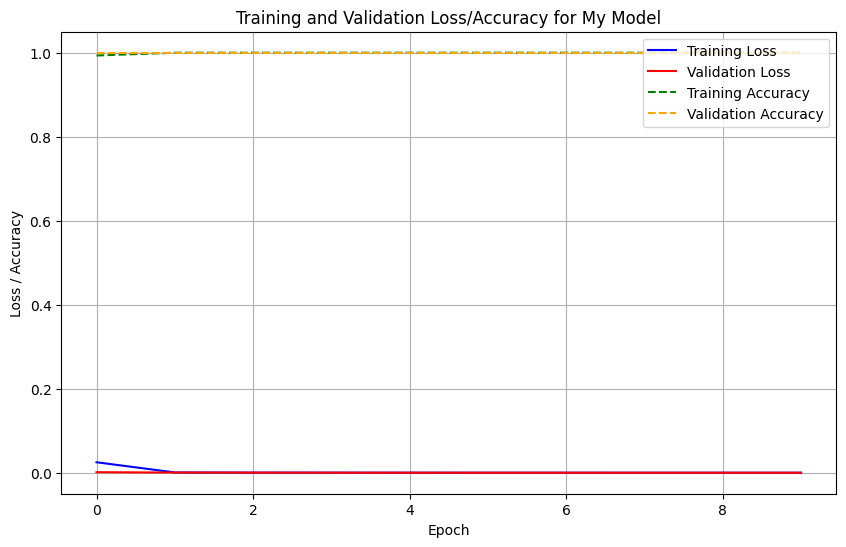

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')

# Add labels, title, and legend
plt.title('Training and Validation Loss/Accuracy for My Model')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()                                                                      #Reference from ChatGPT and Professor Miguel

## **Visualizing and Evaluating the Model**

### **Calculating the F1 score, precision, support and recall**

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting the validation set
y_pred = model.predict(X_val_rgb)
y_pred = (y_pred > 0.5).astype(int)

# Printing classification report
print(classification_report(y_val, y_pred))

# Printing confusion matrix
print(confusion_matrix(y_val, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       209
         1.0       1.00      1.00      1.00        92

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301

[[209   0]
 [  0  92]]


### **Confusion Matrix to Visualize TP, TN, FP and FN**

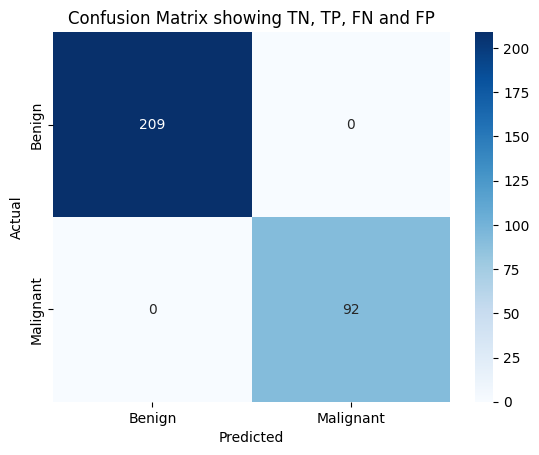

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example: Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix showing TN, TP, FN and FP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()                                                                     #Reference from ChatGPT

In [21]:
# Get predicted probabilities for the positive class (malignant)
y_pred_prob = model.predict(X_val_rgb).flatten()  # Flatten to get a 1D array

10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step


### **Generating the ROC Curve**

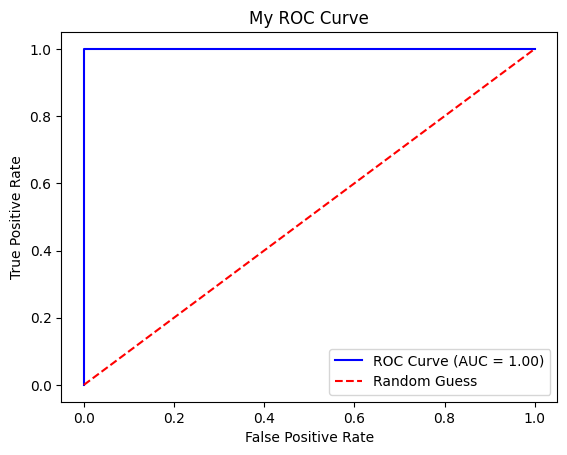

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.title('My ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### **Generating the Precision-Recall Curve**

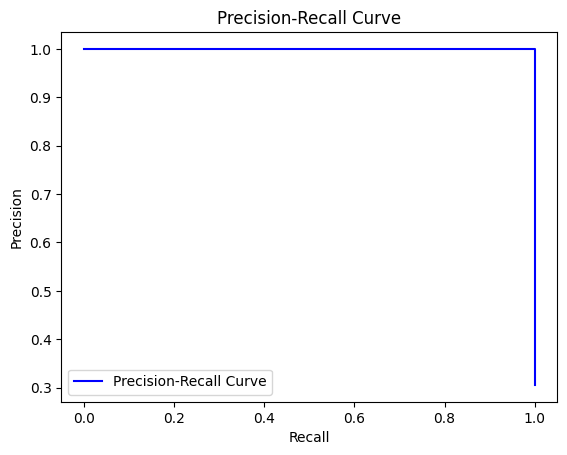

In [24]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

# Plot Precision-Recall curve
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## **Testing**

In [58]:
def preprocess_image(image_path):
    # Load the image (assuming it's a DICOM file)
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array

    # Resize the image to (224, 224)
    image_resized = cv2.resize(image, (224, 224))

    # Normalize pixel values to [0, 1]
    image_normalized = image_resized / 255.0

    # Convert grayscale to 3 channels (for ResNet50)
    image_rgb = np.repeat(image_normalized[..., np.newaxis], 3, axis=-1)

    # Add batch dimension
    image_final = np.expand_dims(image_rgb, axis=0)

    return image_final                                                                #Reference from ChatGPT

### **Analyze FP and FN cases**

False Positives (FP):


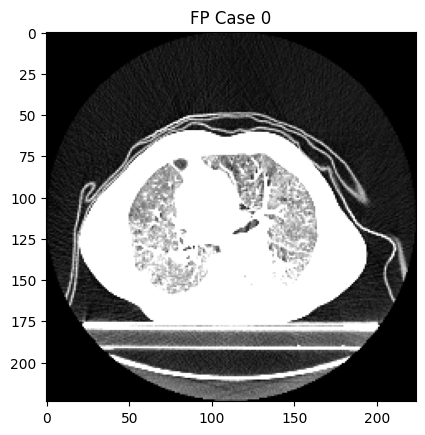

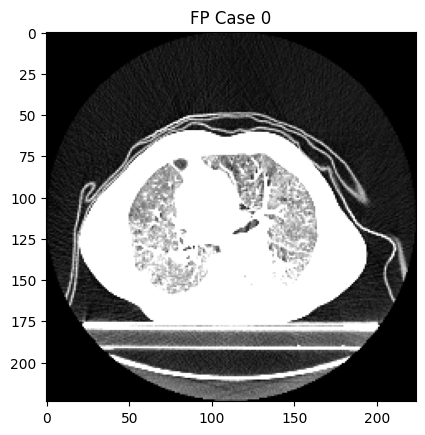

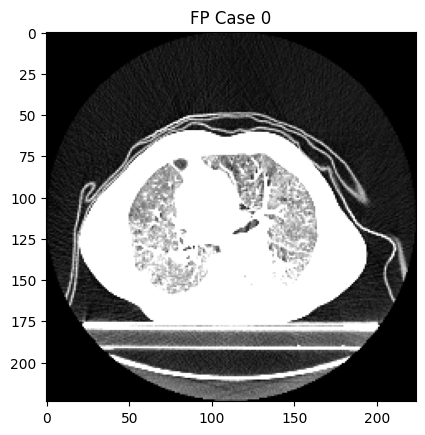

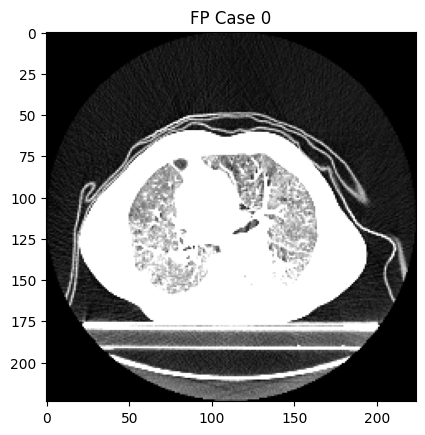

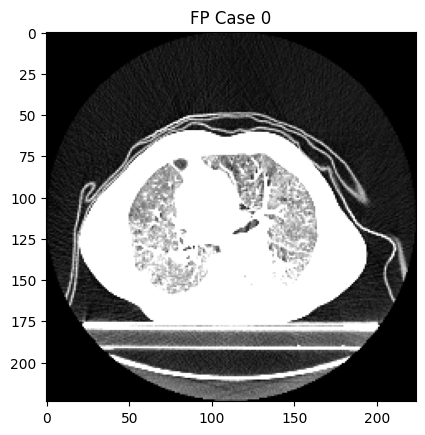

False Negatives (FN):


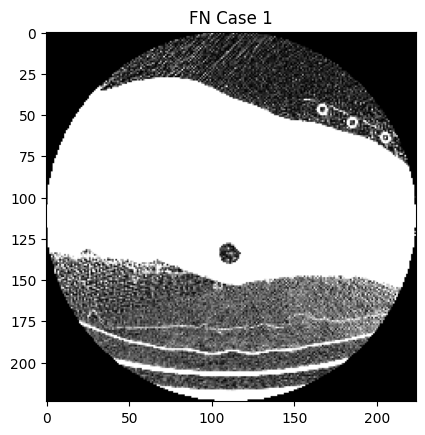

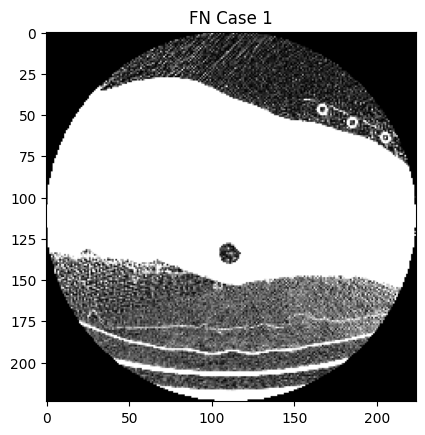

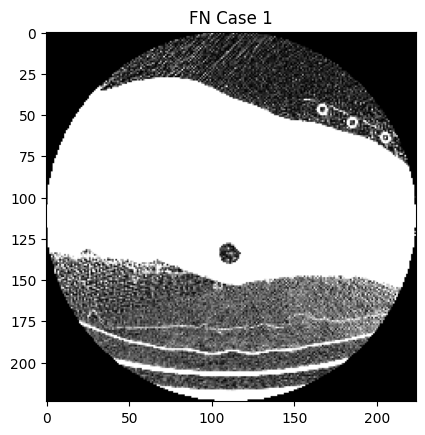

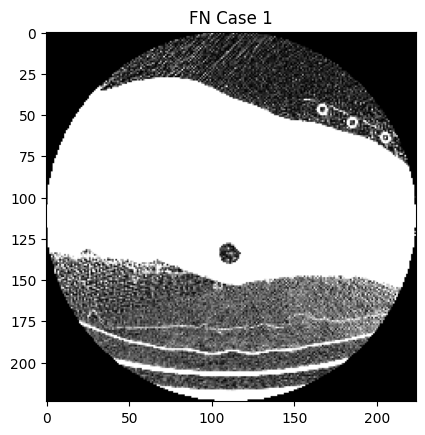

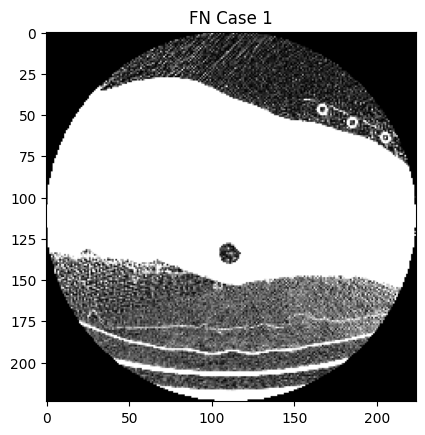

In [64]:
import matplotlib.pyplot as plt

# Find indices of FP and FN cases
fp_indices = np.where((y_val == 0) & (y_pred == 1))[0]
fn_indices = np.where((y_val == 1) & (y_pred == 0))[0]

# Visualize some FP cases
print("False Positives (FP):")
for i in fp_indices[:5]:  # Display first 5 FP cases
    plt.imshow(X_val_rgb[i].squeeze(), cmap='gray')
    plt.title(f"FP Case {i}")
    plt.show()

# Visualize some FN cases
print("False Negatives (FN):")
for i in fn_indices[:5]:  # Display first 5 FN cases
    plt.imshow(X_val_rgb[i].squeeze(), cmap='gray')
    plt.title(f"FN Case {i}")
    plt.show()

FileUpload(value={}, accept='.dcm', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


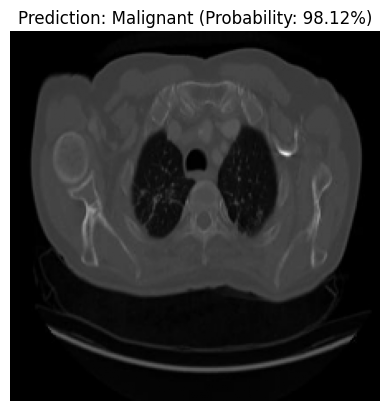

Malignant (Probability: 98.12%)


In [65]:
import ipywidgets as widgets
from IPython.display import display
import pydicom
from pydicom.filebase import DicomBytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt


def preprocess_image(image):
    """
    Preprocess a DICOM image for prediction.
    """
    # Resize the image to (224, 224)
    image_resized = cv2.resize(image, (224, 224))

    # Normalize pixel values to [0, 1]
    image_normalized = image_resized / 255.0

    # Convert grayscale to 3 channels (for ResNet50)
    if len(image_normalized.shape) == 2:  # Grayscale image
        image_rgb = np.repeat(image_normalized[..., np.newaxis], 3, axis=-1)
    else:  # Already RGB or other format
        image_rgb = image_normalized

    # Add batch dimension
    image_final = np.expand_dims(image_rgb, axis=0)

    return image_final, image_resized

def predict_image(image):
    """
    Predict whether an image is benign or malignant.
    """
    # Preprocess the image
    image_final, image_resized = preprocess_image(image)

    # Make a prediction
    prediction = model.predict(image_final)
    probability = prediction[0][0]  # Probability of being malignant

    # Classify as benign or malignant
    if probability > 0.5:
        result = "Malignant (Probability: {:.2f}%)".format(probability * 100)
    else:
        result = "Benign (Probability: {:.2f}%)".format((1 - probability) * 100)

    # Display the image and prediction
    plt.imshow(image_resized, cmap='gray')
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

# Create an upload button
upload_button = widgets.FileUpload(
    accept='.dcm',  # Accept only .dcm files
    multiple=False  # Allow only one file to be uploaded at a time
)

# Display the upload button
display(upload_button)

# Function to handle file upload and prediction
def on_upload_change(change):
    # Check if a file has been uploaded
    if upload_button.value:
        # Get the uploaded file
        uploaded_file = list(upload_button.value.values())[0]

        try:
            # Read the DICOM file from bytes
            dicom_bytes = uploaded_file['content']
            dicom_data = pydicom.dcmread(DicomBytesIO(dicom_bytes))

            # Extract the pixel array
            if hasattr(dicom_data, 'pixel_array'):
                image = dicom_data.pixel_array

                # Ensure the image is 2D (grayscale)
                if len(image.shape) > 2:
                    image = image[:, :, 0]  # Take the first channel if multi-channel

                # Make a prediction
                prediction_result = predict_image(image)
                print(prediction_result)
            else:
                print("Error: The DICOM file does not contain a pixel array.")
        except Exception as e:
            print(f"Error processing the DICOM file: {e}")

# Attach the function to the upload button
upload_button.observe(on_upload_change, names='value')                                          #Reference from DeepSeek